In [1]:
import pandas as pd
import os 
import arrow as ar  #arrow 处理时间日期的模块
import matplotlib.pyplot as plt
import seaborn as sns
from pyplotz.pyplotz import PyplotZ #一个优化matplotlib函数操作的package
import numpy as np
plt.style.use('fivethirtyeight')
from palettable.colorbrewer.sequential import Blues_9,BuGn_9,Greys_3,PuRd_5#三种配色的调色板
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#os.chdir('H:\IJCAI')
pltz=PyplotZ()

train=pd.read_csv('data/round1_ijcai_18_train_20180301.txt', " ")
test=pd.read_csv('data/round1_ijcai_18_test_a_20180301.txt', " ")

In [2]:
print(1)

1


## 数据分析技巧总结：
    1 分析基础信息，包括训练集/测试集样本数量、缺失情况、正负样本比例、重复样本情况、异常值等情况。
    2 特征与标签的关系和数据分布情况。要围绕着与标签或和标签的间接关系的量或与标签值相关量展开。一般情况，标签或间接量当因变量、数据中其他#维度当自变量。
    3 在数据分析过程中，对数据的分析情况做记录、掌握数据情况为后续的工作做铺垫。
    4 很多情况，都要考虑训练集与测试集的特征数据分布情况一致性，也是要通过数据分析得出结论。

## 1 数据探索

### 1.1 基础数据


In [3]:
print('数据集一共有'+str(len(train))+'个样本')

print('标签的比例为'+str(len(train[train.is_trade==0])/len(train[train.is_trade==1])))

数据集一共有478138个样本
标签的比例为52.00277131138455


In [4]:
print('数据中有'+str(len(train['item_id'].unique()))+'不同的广告商品,以及'+str(len(train['shop_id'].unique()))+'个不同的商铺')

数据中有10075不同的广告商品,以及3959个不同的商铺


In [5]:
#探查下出现频率最高的各类型id
for x in ['instance_id','is_trade','item_id','user_id','context_id','shop_id']:
    print(x,"出现频率最高的前5个id以及出现次数")
    print(train[x].value_counts().head(5))
    print("------------------------------------")

instance_id 出现频率最高的前5个id以及出现次数
5479907258807096112    3
3370133319712542740    3
2535273059737073357    2
4984307821968110563    2
6031880284089240838    2
Name: instance_id, dtype: int64
------------------------------------
is_trade 出现频率最高的前5个id以及出现次数
0    469117
1      9021
Name: is_trade, dtype: int64
------------------------------------
item_id 出现频率最高的前5个id以及出现次数
7571023501622243456    3001
2986722878397696833    2836
5410526681843914464    2578
2079092401639430105    2515
2709839111509701702    2448
Name: item_id, dtype: int64
------------------------------------
user_id 出现频率最高的前5个id以及出现次数
7201324926905945581    65
9077306189515288541    56
4221535911244811523    53
6040154960559072464    50
7147341411281829756    46
Name: user_id, dtype: int64
------------------------------------
context_id 出现频率最高的前5个id以及出现次数
290808226164722964     3
7259819519976136023    3
393440996556281300     2
6603062751043810606    2
8100475734761363134    2
Name: context_id, dtype: int64
-----------------

In [6]:
count = 0
for l in list(train["instance_id"].value_counts()):
    if l > 1:
        count += 1
print(count)

49


## 分析结果：
    1 正负样本比例较均衡，约为52：1，出现严重数据倾斜，要考虑对数据倾斜进行处理。
    2 数据集一共有478138个样本、数据中有10075不同的广告商品,以及3959个不同的商
    3 instance_id有少量重复(49个)，考虑直接删除
    4 有大量重复的商品和店铺，符合电商的长尾分布规律。后期特征数据处理的时候考虑对数据长尾分布进行处理。
    可进一步分析用户出现频率占比、店铺出现频率占比、商品出现频率占比，
    
    注：电商长尾分布现象解释
    最受欢迎的一部分产品，数量不多，但是销售量很大。长尾指的就是右侧的“long tail”，但是每一个单个产品需求和销售都很小的那一部分。长尾可以延长到接近无穷。虽然长尾部分的每个产品销量不多，但是因为长尾长，总的销量以及利润与头部可以相媲美。这种效应也只有在互联网上才能实现。

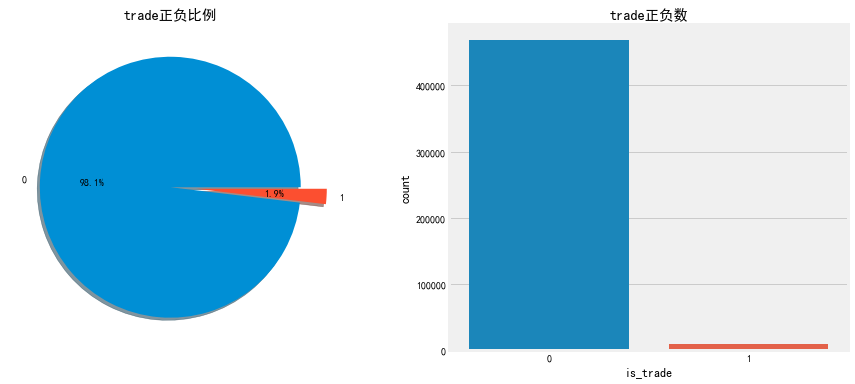

In [7]:
#使用饼图,看看样本正负比例
import pylab
pylab.mpl.rcParams['font.sans-serif'] = ['SimHei']

f,ax=plt.subplots(1,2,figsize=(14,6))
train['is_trade'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('trade正负比例')
ax[0].set_ylabel('')
sns.countplot('is_trade',data=train,ax=ax[1])
ax[1].set_title('trade正负数')
plt.show()

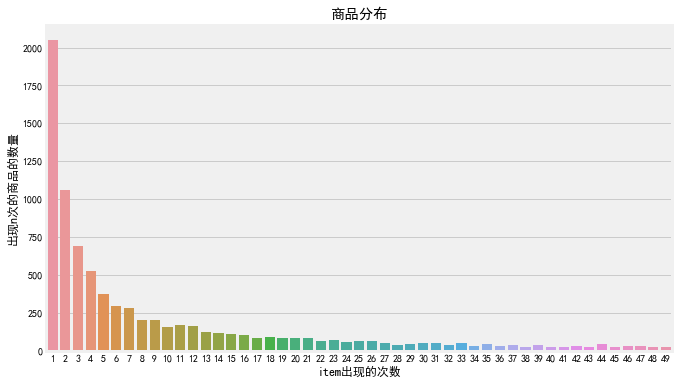

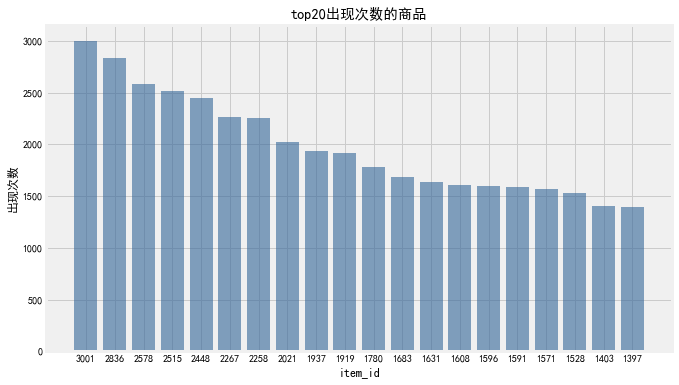

In [8]:
fig, axis1 = plt.subplots(1,1,figsize=(10,6))
item_num=pd.DataFrame({'item_id_num':train['item_id'].value_counts().values})
sns.countplot(x='item_id_num',data=item_num[item_num['item_id_num']<50])
axis1.set_xlabel('item出现的次数')
axis1.set_ylabel('出现n次的商品的数量')
axis1.set_title('商品分布')


fig, axis1 = plt.subplots(1,1,figsize=(10,6))

item_value=pd.DataFrame(train.item_id.value_counts()).reset_index().head(20)
axis1.set_xlabel('item_id')
axis1.set_ylabel('出现次数')
axis1.set_title('top20出现次数的商品')
y_pos = np.arange(len(item_value))

plt.bar(y_pos, item_value['item_id'], color=(0.2, 0.4, 0.6, 0.6))
pltz.xticks(y_pos, item_value['item_id'])
pltz.show()

## 分析结果：
    1 多数商品出现的次数较少，主要集中在15次之内；
    2 出现次数top20的商品id为：3001,2836,2578,2515,2448,2267,2258,2021,1937,1919,1780,1683,1631,1608,1596,1591,1571,1528,1403,1397；
    3 符合电商商品长尾分布规律。

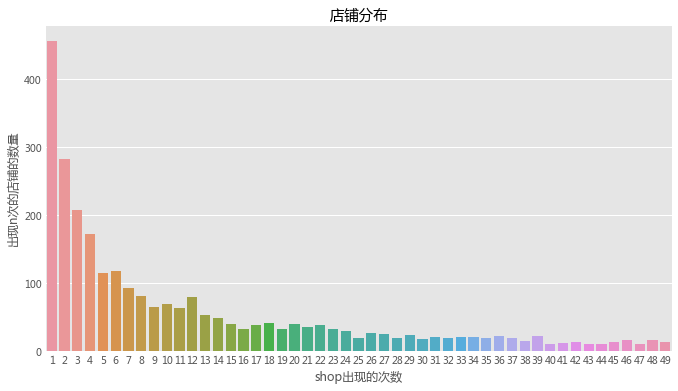

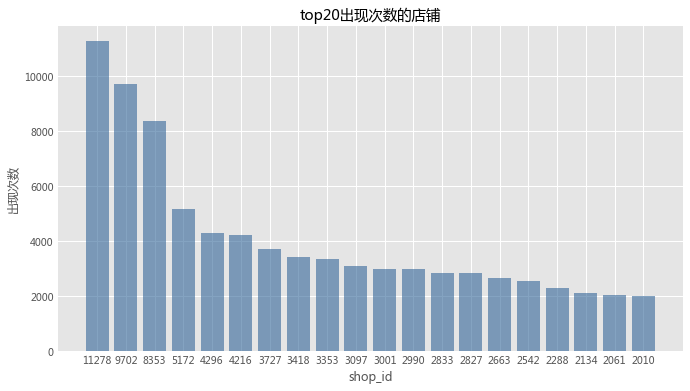

In [292]:
fig, axis1 = plt.subplots(1, 1, figsize=(10, 6))
shop_num = pd.DataFrame({'shop_id_num': train['shop_id'].value_counts().values})
sns.countplot(x='shop_id_num', data=shop_num[shop_num['shop_id_num'] < 50])
axis1.set_xlabel('shop出现的次数')
axis1.set_ylabel('出现n次的店铺的数量')
axis1.set_title('店铺分布')

fig, axis1 = plt.subplots(1, 1, figsize=(10, 6))

shop_value = pd.DataFrame(train.shop_id.value_counts()).reset_index().head(20)
axis1.set_xlabel('shop_id')
axis1.set_ylabel('出现次数')
axis1.set_title('top20出现次数的店铺')
y_pos = np.arange(len(shop_value))

plt.bar(y_pos, shop_value['shop_id'], color=(0.2, 0.4, 0.6, 0.6))
pltz.xticks(y_pos, shop_value['shop_id'])
pltz.show()

## 分析结果：
    与商品分布的分析结果基本一致。

### 2.2 用户信息

In [15]:
train.columns

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade'],
      dtype='object')

In [19]:
for x in ['user_gender_id','user_age_level','user_occupation_id','user_star_level']:
    print("用户信息中%s出现频率top5"%x)
    print(train[x].value_counts().head(5))
    print("------------------------------------")

用户信息中user_gender_id出现频率top5
 0    360817
 1     94070
-1     12902
 2     10349
Name: user_gender_id, dtype: int64
------------------------------------
用户信息中user_age_level出现频率top5
1003    169449
1004    126131
1002     70175
1005     56608
1006     30190
Name: user_age_level, dtype: int64
------------------------------------
用户信息中user_occupation_id出现频率top5
 2005    300036
 2002    146917
 2004     23803
 2003      6418
-1          964
Name: user_occupation_id, dtype: int64
------------------------------------
用户信息中user_star_level出现频率top5
3006    82009
3003    74578
3005    67440
3002    62921
3004    61769
Name: user_star_level, dtype: int64
------------------------------------


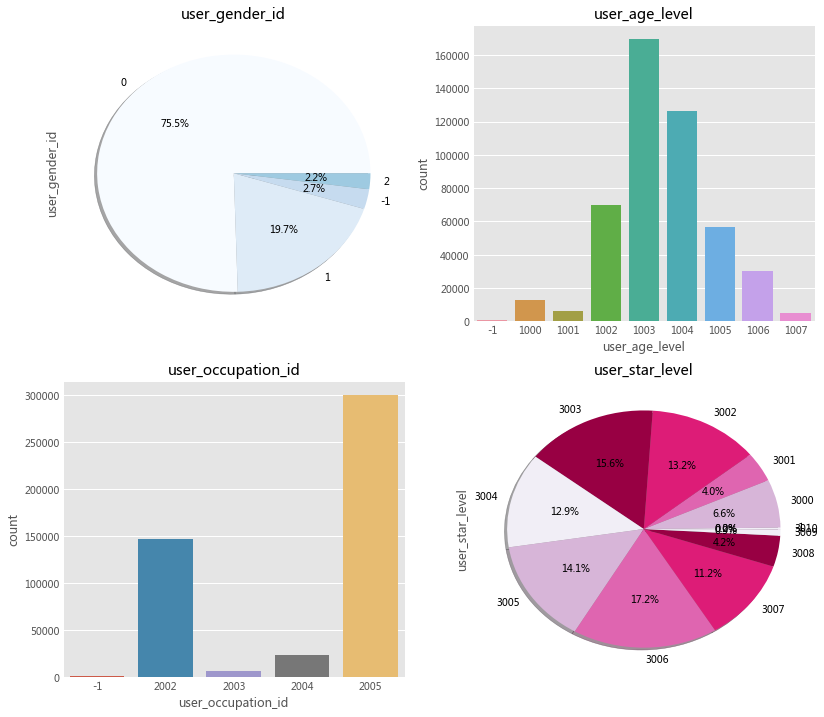

In [298]:
f,ax=plt.subplots(2,2,figsize=(12,12))
train['user_gender_id'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True,colors=Blues_9.hex_colors)
ax[0][0].set_title('user_gender_id')

sns.countplot('user_age_level',data=train,ax=ax[0][1])
ax[0][1].set_title('user_age_level')

sns.countplot('user_occupation_id',data=train,ax=ax[1][0])
ax[1][0].set_title('user_occupation_id')

train['user_star_level'].value_counts().sort_index().plot.pie(autopct='%1.1f%%',ax=ax[1][1],shadow=True,colors=PuRd_5.hex_colors)
ax[1][1].set_title('user_star_level')

plt.show()

## 分析结果：
    用户基本属性在以往数据中出现的占比情况
    1 女性在购物中占大多数，占比为75.5%
    2 消费人群年龄主要分布在1002、1003、1004，其中1003年龄属性的人群最活跃(序号越大，年龄越大)
    3 2002、2005职业的人群比较活跃
    4 用户星级对出现的次数也有一定的影响
    综上，性别、年龄、职业、用户星级 这四个基本属性对用户 行为也是有影响的，考虑入模型的特征中。

### 2.3 店铺信息

In [20]:
for x in ['shop_review_num_level','shop_star_level']:
    print(train[x].value_counts())

17    81437
16    79295
15    65954
14    50727
18    50617
13    31051
20    24914
21    22855
12    18673
19    16230
11    14008
10     8598
9      5484
8      3089
7      1849
6      1343
22      619
5       578
23      353
4       266
2        87
3        80
1        20
0         7
25        4
Name: shop_review_num_level, dtype: int64
5013    82641
5014    81596
5015    73992
5012    73611
5011    34356
5018    25075
5010    24487
5017    23243
5016    19239
5009    18191
5008     8480
5007     5500
5006     3087
5005     1459
5003     1266
5004      863
5002      477
5020      357
5000       81
5019       70
5001       60
4999        7
Name: shop_star_level, dtype: int64


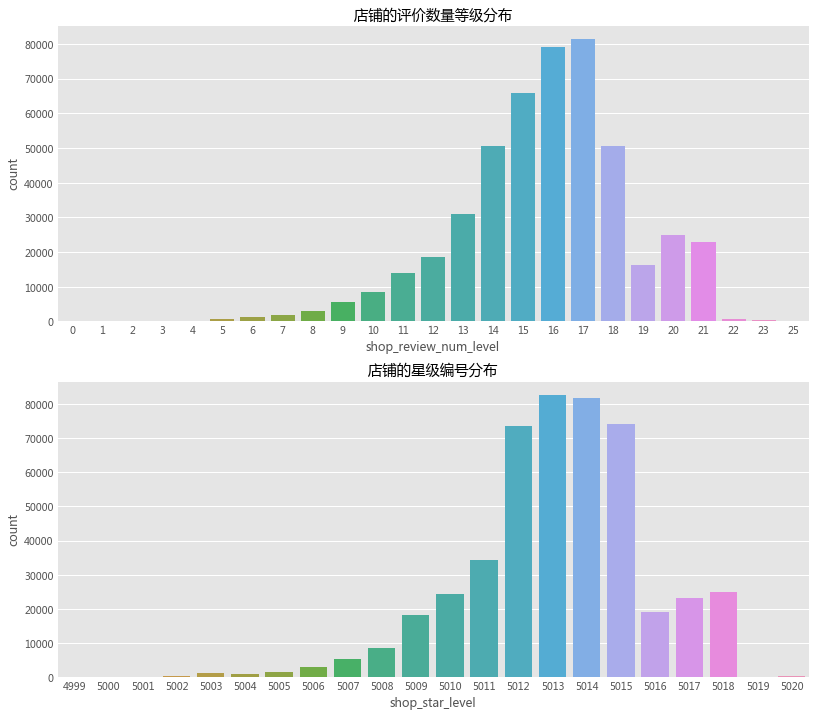

In [303]:
f,ax=plt.subplots(2,1,figsize=(12,12))
sns.countplot('shop_review_num_level',data=train,ax=ax[0])
ax[0].set_title('店铺的评价数量等级分布')

sns.countplot('shop_star_level',data=train,ax=ax[1])
ax[1].set_title('店铺的星级编号分布')

Text(0.5, 1.0, '店铺的描述相符评分')

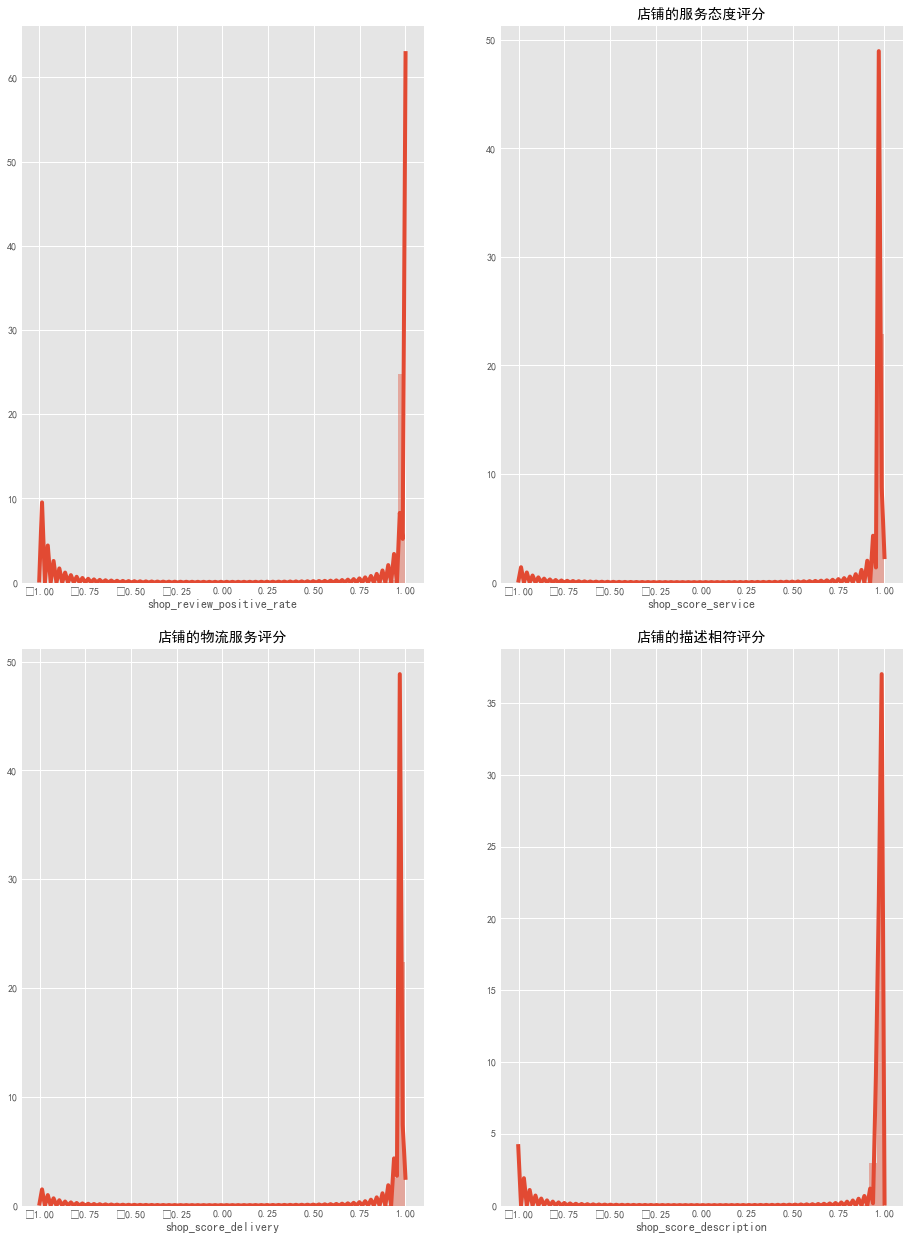

In [33]:
plt.style.use('ggplot')
f,ax=plt.subplots(2,2,figsize=(14,18))  ###***f,ax=plt.subplots(m,n,figsize=(14,18))图表中建了m*n张表格
plt.tight_layout(5)
#sns.boxplot(y=train['shop_review_positive_rate'][train['shop_review_positive_rate']!=-1],ax=ax[0][0])
sns.distplot(train['shop_review_positive_rate'],ax=ax[0][0]) #[train['shop_review_positive_rate']>0.98]
ax[0][1].set_title('店铺的好评率')

#sns.boxplot(y=train['shop_score_service'][train['shop_score_service']!=-1],ax=ax[1][0])
sns.distplot(train['shop_score_service'],ax=ax[0][1]) #[train['shop_score_service']>0.9]
ax[0][1].set_title('店铺的服务态度评分')


#sns.boxplot(y=train['shop_score_delivery'][train['shop_score_delivery']!=-1],ax=ax[2][0])
sns.distplot(train['shop_score_delivery'],ax=ax[1][0])  #[train['shop_score_delivery']>0.9]
ax[1][0].set_title('店铺的物流服务评分')




#sns.boxplot(y=train['shop_score_description'][train['shop_score_description']!=-1],ax=ax[3][0])
sns.distplot(train['shop_score_description'],ax=ax[1][1])  #[train['shop_score_description']>0.9]
ax[1][1].set_title('店铺的描述相符评分')

## 分析结果：
    1 店铺四个评分指标存在异常值情况，在做数据预处理的时候要考虑把这些异常值剔除
    不考虑异常值情况，四个评分指标的数据成高斯分布，评分指标对该条广告是否被交易也存在一定程度的影响。

Text(0.5, 1.0, '店铺的描述相符评分')

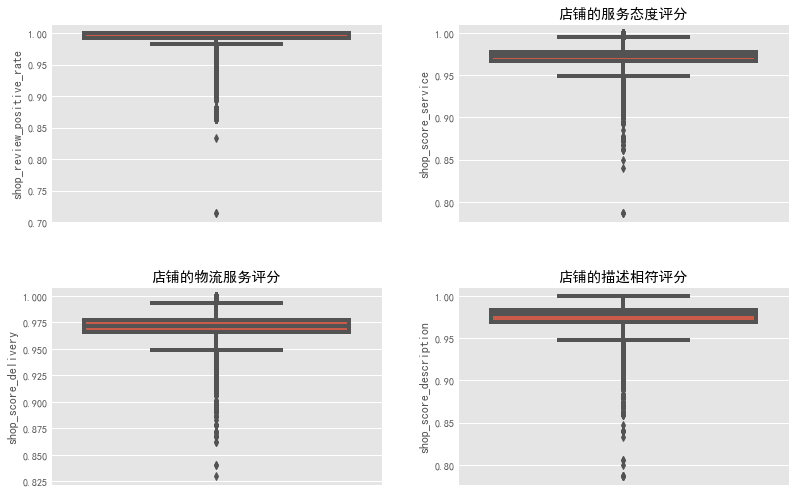

In [39]:
#找出异常边界
f,ax=plt.subplots(2,2,figsize=(12,8))  ###***f,ax=plt.subplots(m,n,figsize=(14,18))图表中建了m*n张表格
plt.tight_layout(5)
sns.boxplot(y=train['shop_review_positive_rate'][train['shop_review_positive_rate']!=-1],ax=ax[0][0])
#sns.distplot(train['shop_review_positive_rate'],ax=ax[0][0]) #[train['shop_review_positive_rate']>0.98]
ax[0][1].set_title('店铺的好评率')

sns.boxplot(y=train['shop_score_service'][train['shop_score_service']!=-1],ax=ax[0][1])
#sns.distplot(train['shop_score_service'],ax=ax[0][1]) #[train['shop_score_service']>0.9]
ax[0][1].set_title('店铺的服务态度评分')


sns.boxplot(y=train['shop_score_delivery'][train['shop_score_delivery']!=-1],ax=ax[1][0])
#sns.distplot(train['shop_score_delivery'],ax=ax[1][0])  #[train['shop_score_delivery']>0.9]
ax[1][0].set_title('店铺的物流服务评分')




sns.boxplot(y=train['shop_score_description'][train['shop_score_description']!=-1],ax=ax[1][1])
#sns.distplot(train['shop_score_description'],ax=ax[1][1])  #[train['shop_score_description']>0.9]
ax[1][1].set_title('店铺的描述相符评分')

## 分析结果：
    店铺的好评率异常临界：下界=0.98，取0.90
    店铺的服务态度评分异常临界：下界=0.95，取0.90
    店铺的物流服务评分异常临界：下界=0.95，取0.90
    店铺的描述相符评分异常临界：下界=0.95，取0.90
    

Text(0.5, 1.0, '店铺的描述相符评分')

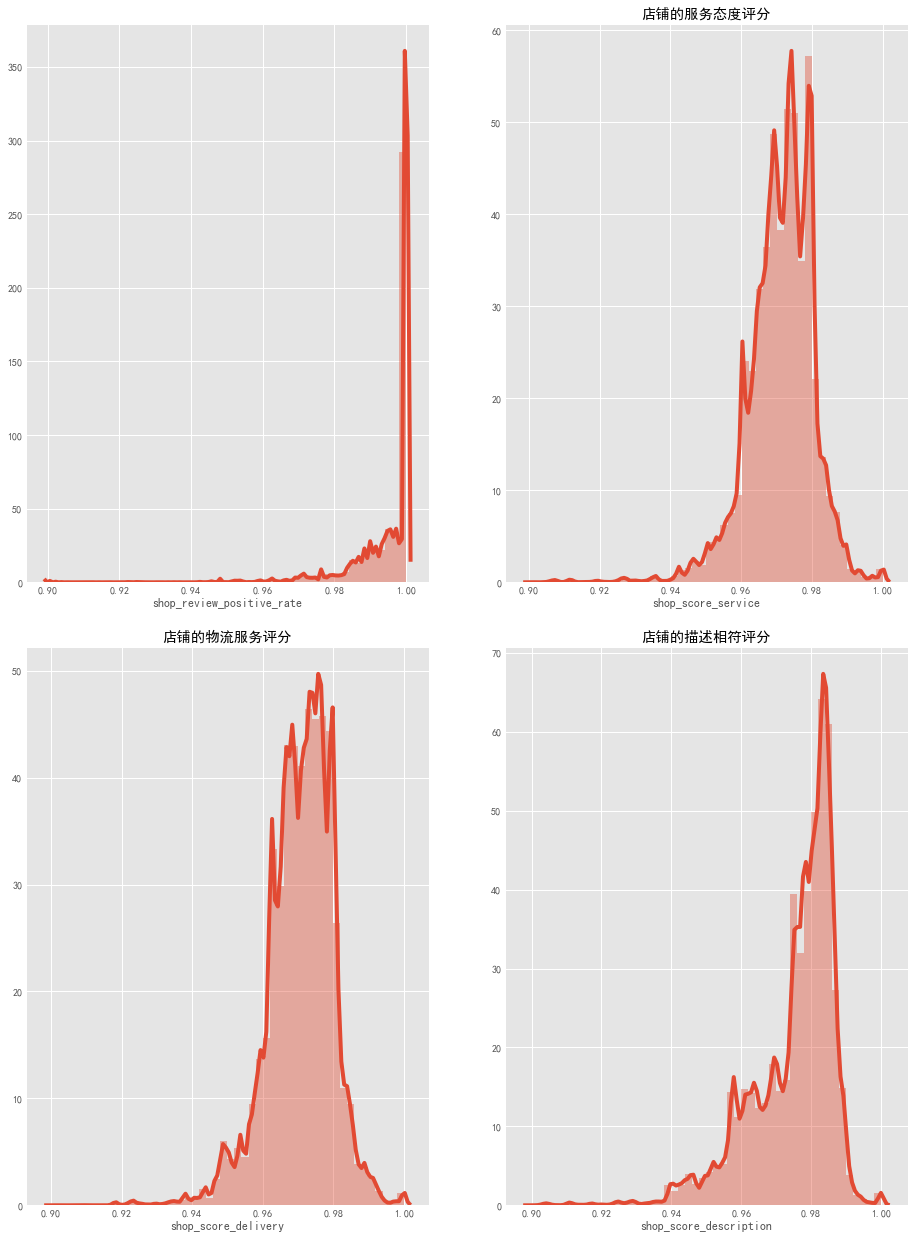

In [40]:
f,ax=plt.subplots(2,2,figsize=(14,18))  ###***f,ax=plt.subplots(m,n,figsize=(14,18))图表中建了m*n张表格
plt.tight_layout(5)
#sns.boxplot(y=train['shop_review_positive_rate'][train['shop_review_positive_rate']!=-1],ax=ax[0][0])
sns.distplot(train['shop_review_positive_rate'][train['shop_review_positive_rate']>0.90],ax=ax[0][0]) #[train['shop_review_positive_rate']>0.98]
ax[0][1].set_title('店铺的好评率')

#sns.boxplot(y=train['shop_score_service'][train['shop_score_service']!=-1],ax=ax[1][0])
sns.distplot(train['shop_score_service'][train['shop_score_service']>0.9],ax=ax[0][1]) #[train['shop_score_service']>0.9]
ax[0][1].set_title('店铺的服务态度评分')


#sns.boxplot(y=train['shop_score_delivery'][train['shop_score_delivery']!=-1],ax=ax[2][0])
sns.distplot(train['shop_score_delivery'][train['shop_score_delivery']>0.9],ax=ax[1][0])  #[train['shop_score_delivery']>0.9]
ax[1][0].set_title('店铺的物流服务评分')

#sns.boxplot(y=train['shop_score_description'][train['shop_score_description']!=-1],ax=ax[3][0])
sns.distplot(train['shop_score_description'][train['shop_score_description']>0.9],ax=ax[1][1])  #[train['shop_score_description']>0.9]
ax[1][1].set_title('店铺的描述相符评分')

## 分析结果：
    不考虑异常值情况，四个评分指标的数据成高斯分布，评分指标对该条广告是否被交易也存在一定程度的影响。

## 2.4 广告商品信息


In [42]:
for x in ['item_brand_id','item_city_id','item_price_level','item_sales_level','item_collected_level','item_pv_level']:
    print("%s出现次数top5的id"%x)
    print(train[x].value_counts().head(5))
    print("-------------------------------")

item_brand_id出现次数top5的id
7838285046767229711    69746
7066302540842412840    13823
5051039799137810159    13045
448955875785543916     10116
739382823914881928      6542
Name: item_brand_id, dtype: int64
-------------------------------
item_city_id出现次数top5的id
7534238860363577544    154991
7322157373578955368     58326
3948283326616421003     54472
5918626470536001929     34952
196257267849351217      30276
Name: item_city_id, dtype: int64
-------------------------------
item_price_level出现次数top5的id
7    209285
8    115587
6     89057
5     41057
4     14607
Name: item_price_level, dtype: int64
-------------------------------
item_sales_level出现次数top5的id
12    86960
11    80440
13    64451
10    57664
14    44525
Name: item_sales_level, dtype: int64
-------------------------------
item_collected_level出现次数top5的id
12    84601
13    84050
14    73771
11    53010
15    46410
Name: item_collected_level, dtype: int64
-------------------------------
item_pv_level出现次数top5的id
18    102083
17     8

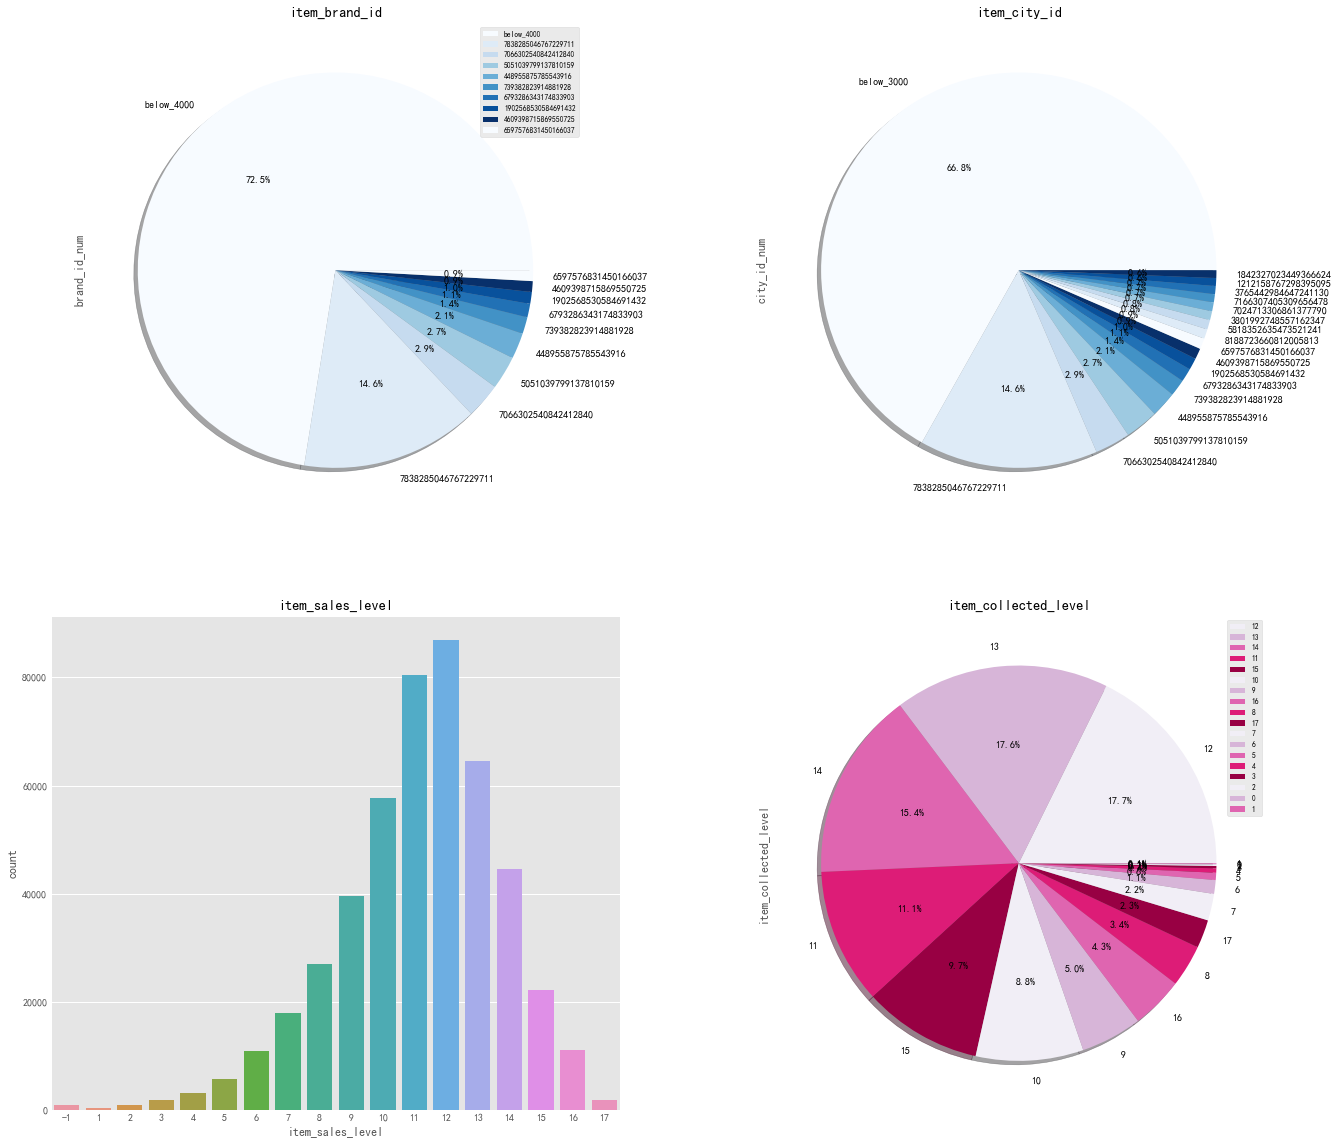

In [56]:
f,ax=plt.subplots(2,2,figsize=(20,20))

item_brand_id_num=pd.DataFrame({'brand_id_num':train['item_brand_id'].value_counts()}).reset_index()
brand_value=pd.DataFrame({'brand_id_num':item_brand_id_num['brand_id_num'][item_brand_id_num['brand_id_num']<4000].sum()},index=[0])
brand_value['index']='below_4000'
brand_value=pd.concat([brand_value,item_brand_id_num[item_brand_id_num['brand_id_num']>=4000]])
pd.Series(data=brand_value.set_index('index')['brand_id_num']).plot.pie(autopct='%1.1f%%',ax=ax[0][0],shadow=True,colors=Blues_9.hex_colors)

ax[0][0].set_title('item_brand_id')
ax[0][0].legend(fontsize=7.5)
#sns.countplot('item_city_id',data=train,ax=ax[0][1])


item_city_id_num=pd.DataFrame({'city_id_num':train['item_brand_id'].value_counts()}).reset_index()
city_value=pd.DataFrame({'city_id_num':item_city_id_num['city_id_num'][item_city_id_num['city_id_num']<3000].sum()},index=[0])
city_value['index']='below_3000'
city_value=pd.concat([city_value,item_city_id_num[item_brand_id_num['brand_id_num']>=3000]])
pd.Series(data=city_value.set_index('index')['city_id_num']).plot.pie(autopct='%1.1f%%',ax=ax[0][1],shadow=True,colors=Blues_9.hex_colors)
ax[0][1].set_title('item_city_id')

sns.countplot('item_sales_level',data=train,ax=ax[1][0])
ax[1][0].set_title('item_sales_level')

train['item_collected_level'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1][1],shadow=True,colors=PuRd_5.hex_colors)
ax[1][1].set_title('item_collected_level')
ax[1][1].legend(fontsize=7.5)
plt.show()